<a href="https://colab.research.google.com/github/hyunchangyi/papers/blob/main/jupyter/covid-inf-rate/SantaClara_CmdStanR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Bayesian analysis inference of coronavirus infection rate from the Stanford study in Santa Clara county

This Google Colab Python notebook provides the models and data discussed here:  [Simple Bayesian analysis inference of coronavirus infection rate from the Stanford study in Santa Clara county](https://statmodeling.stat.columbia.edu/2020/05/01/simple-bayesian-analysis-inference-of-coronavirus-infection-rate-from-the-stanford-study-in-santa-clara-county/)

It uses CmdStanR to compile and fit the model.

#### First up, a little admin to get the latest CmdStanR and CmdStan installed on this instance.

In [1]:
# Preliminary setup
install.packages('versions')
library(versions)
# Install package CmdStanR from GitHub
library(devtools)
if(!require(cmdstanr)){
  devtools::install_github("stan-dev/cmdstanr", dependencies=c("Depends", "Imports"))
  library(cmdstanr)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: usethis

Loading required package: cmdstanr

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘cmdstanr’”



withr        (2.4.3 -> 2.5.0     ) [CRAN]
numDeriv     (NA    -> 2016.8-1.1) [CRAN]
rlang        (1.0.1 -> 1.0.2     ) [CRAN]
matrixStats  (NA    -> 0.61.0    ) [CRAN]
distribut... (NA    -> 0.3.0     ) [CRAN]
tensorA      (NA    -> 0.36.2    ) [CRAN]
checkmate    (NA    -> 2.0.0     ) [CRAN]
abind        (NA    -> 1.4-5     ) [CRAN]
posterior    (NA    -> 1.2.1     ) [CRAN]


Installing 9 packages: withr, numDeriv, rlang, matrixStats, distributional, tensorA, checkmate, abind, posterior

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



* checking for file ‘/tmp/RtmpG3h2r5/remotes3d920951e/stan-dev-cmdstanr-ac5a448/DESCRIPTION’ ... OK
* preparing ‘cmdstanr’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘cmdstanr/tests/testthat/answers/model-code-output.rds’
* building ‘cmdstanr_0.4.0.9001.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

This is cmdstanr version 0.4.0.9001

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- Use set_cmdstan_path() to set the path to CmdStan

- Use install_cmdstan() to install CmdStan



In [2]:
# Install CmdStan binaries
if (!file.exists("cmdstan-2.23.0.tar.gz")) {
  system("wget https://github.com/stan-dev/cmdstan/releases/download/v2.23.0/colab-cmdstan-2.23.0.tar.gz", intern=T)
  system("tar zxf colab-cmdstan-2.23.0.tar.gz", intern=T)
}
list.files("cmdstan-2.23.0")

character(0)

[1] "bin"                "examples"           "install-tbb.bat"   
 [4] "Jenkinsfile"        "lib"                "LICENSE"           
 [7] "make"               "makefile"           "README.md"         
[10] "runCmdStanTests.py" "src"                "stan"              
[13] "test-all.sh"

In [3]:
# Set cmdstan_path to CmdStan installation
set_cmdstan_path("cmdstan-2.23.0")

CmdStan path set to: /content/cmdstan-2.23.0



In [4]:
# helper function
print_file <- function(file, nlines=-1L) {
  cat(paste(readLines(file, n=nlines), "\n", sep=""), sep="")
}

#### Upload models and data from GitHub

The models and data are available on the Stan GitHub repo https://github.com/stan-dev/example-models/tree/master/jupyter/covid-inf-rate

In [5]:
system("wget https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/data/santa_clara_all.data.json", intern=T)
system("wget https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/data/santa_clara_apr_11.data.json", intern=T)
system("wget https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/data/santa_clara_apr_27.data.json", intern=T)
system("wget https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/stan/pool_sens_spec.stan", intern=T)
system("wget https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/stan/hier_sens_spec.stan", intern=T)
system("wget https://raw.githubusercontent.com/stan-dev/example-models/master/jupyter/covid-inf-rate/stan/hier_sens_spec_offset_mult.stan", intern=T)
list.files()



character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

[1] "cmdstan-2.23.0"                  "colab-cmdstan-2.23.0.tar.gz"    
[3] "hier_sens_spec_offset_mult.stan" "hier_sens_spec.stan"            
[5] "pool_sens_spec.stan"             "sample_data"                    
[7] "santa_clara_all.data.json"       "santa_clara_apr_11.data.json"   
[9] "santa_clara_apr_27.data.json"

In the Santa Clara study, of the 3330 people tested (`n_sample`), 50 test results were positive (`y_sample`).  The first version of the paper was released on April 11th, and used specificity data from two studies and sensitivity data from two other studies.


In [6]:
print_file("santa_clara_apr_11.data.json")

{
    "y_sample" : 50,
    "n_sample" : 3330,
    "y_spec" : 399,
    "n_spec" : 401,
    "y_sens" : 105,
    "n_sens" : 122
}


### Simple Model

The first Stan model in this blogpost is called "santaclara.stan".  It a complete pooling model, therefore we'll call it "pool_sens_spec.stan".

In [7]:
print_file("pool_sens_spec.stan")

/**
 * meta-analysis over studies of disease infection rate 
 * for variation in sensitivity and specificity
 * pool data from all studies
 */
data {
  int y_sample;
  int n_sample;
  int y_spec;
  int n_spec;
  int y_sens;
  int n_sens;
}
parameters {
  real<lower=0, upper=1> p;
  real<lower=0, upper=1> spec;
  real<lower=0, upper=1> sens;
}
model {
  real p_sample;
  p_sample = p * sens + (1 - p) * (1 - spec);
  y_sample ~ binomial(n_sample, p_sample);
  y_spec ~ binomial(n_spec, spec);
  y_sens ~ binomial(n_sens, sens);
}


We use CmdStanR to compile and fit the model to the data.

In [8]:
pool_model <- cmdstan_model(stan_file='pool_sens_spec.stan')
apr_11_fit <- pool_model$sample(data='santa_clara_apr_11.data.json')


Running MCMC with 4 sequential chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Ite

In [9]:
options(digits = 2)
apr_11_fit$summary()


variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-334.80,-334.454,1.2931,1.0571,-3.4e+02,-333.397,1,1411,1695
p,0.01,0.011,0.0045,0.0047,2.4e-03,0.018,1,1554,1397
spec,0.99,0.994,0.0033,0.0035,9.9e-01,0.998,1,1435,1787
sens,0.85,0.855,0.0322,0.0321,8.0e-01,0.901,1,2089,2170


Given the April 11th dataset, the central 95% interval is [0.002 - 0.017], thus the data are consistent with an underlying infection rate of between 0 and 2%.

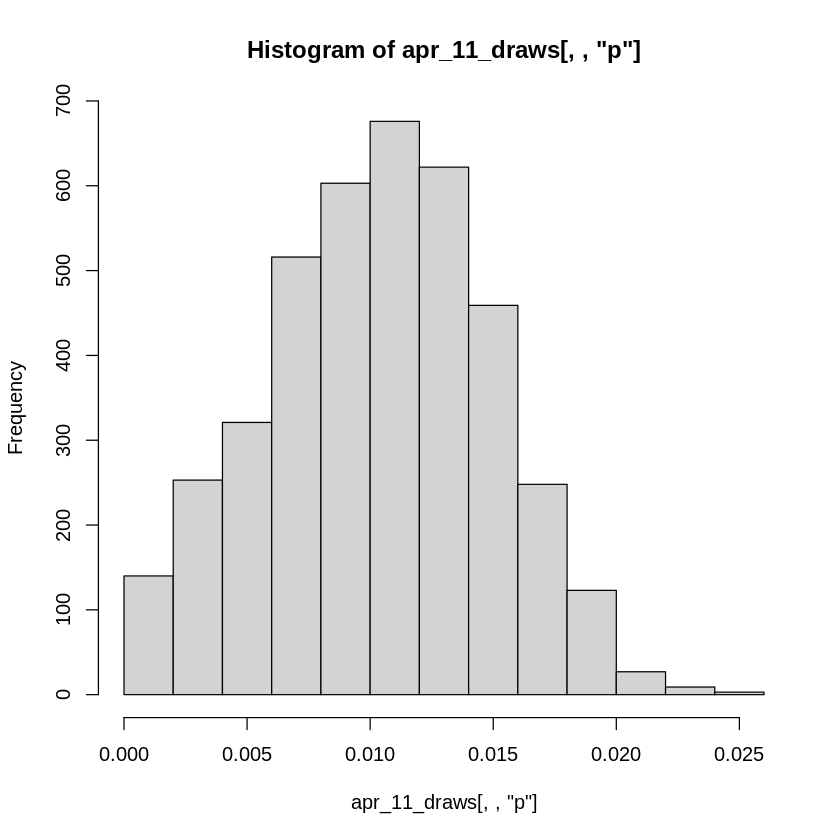

In [10]:
apr_11_draws <- apr_11_fit$draws()
hist(apr_11_draws[,,"p"])

We repeat this procedure with the data from the April 27th version of the study, which has specificity data from 13 studies and sensitivity data from 3 studies.  Again, we pool the results from all studies.

In [11]:
apr_27_fit <- pool_model$sample(data='santa_clara_apr_27.data.json')


Running MCMC with 4 sequential chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 1 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 1 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 1600 / 2000 [ 80%]  (Sampling) 
Chain 1 Iteration: 1700 / 2000 [ 85%]  (Sampling) 
Chain 1 Ite

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-446.107,-445.788,1.2261,0.9904,-448.512,-444.799,1,1959,2501
p,0.013,0.013,0.0030,0.0030,0.008,0.018,1,2478,2205
spec,0.995,0.995,0.0012,0.0012,0.993,0.997,1,2535,2648
sens,0.822,0.824,0.0300,0.0310,0.772,0.868,1,2637,2318


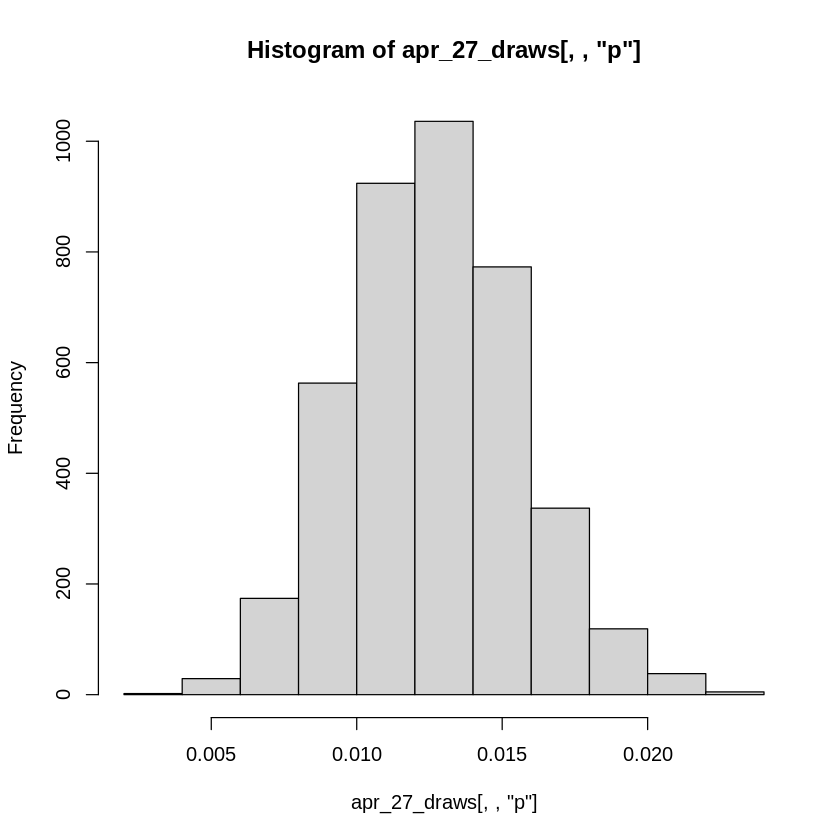

In [12]:
apr_27_fit$summary()
apr_27_draws <- apr_27_fit$draws()
hist(apr_27_draws[,,"p"])


### Hierarchical Model

The hierarchical model allows the sensitivities and specificities to vary across studies.
In the blogpost is called "santaclara_hier.stan".  We'll call it "hier_sens_spec.stan



In [13]:
print_file("hier_sens_spec.stan")

/**
 * meta-analysis of disease infection rate studies
 * hierarchical model of sensitivity and specificity
 * non-centered parameterization
 */
data {
  int y_sample;
  int n_sample;
  int J_spec;
  array[J_spec] int y_spec;
  array[J_spec] int n_spec;
  int J_sens;
  array[J_sens] int y_sens;
  array[J_sens] int n_sens;
}
parameters {
  real<lower=0, upper=1> p;
  real mu_spec;
  real<lower=0> sigma_spec;
  real mu_sens;
  real<lower=0> sigma_sens;
  vector[J_spec] e_spec;
  vector[J_sens] e_sens;
}
transformed parameters {
  vector[J_spec] spec;
  vector[J_sens] sens;
  spec = inv_logit(mu_spec + sigma_spec * e_spec);
  sens = inv_logit(mu_sens + sigma_sens * e_sens);
}
model {
  real p_sample;
  p_sample = p * sens[1] + (1 - p) * (1 - spec[1]);
  y_sample ~ binomial(n_sample, p_sample);
  y_spec ~ binomial(n_spec, spec);
  y_sens ~ binomial(n_sens, sens);
  e_spec ~ normal(0, 1);
  e_sens ~ normal(0, 1);
  sigma_spec ~ normal(0, 1);
  sigma_sens ~ normal(0, 0.2);
}


__Note__: this model has the suggested tight prior on `sigma_sens` in order to compensate for only having data from 3 studies to fit.

For this model, the data is broken out by study.  We copied this data out of page 19 of the report and munged it into the forms required by the model's data block variable definitions.

In [14]:
print_file("santa_clara_all.data.json")

{
    "y_sample" : 50,
    "n_sample" : 3330,
    "J_spec" : 14,
    "J_sens" : 4,
    "y_spec" : [0,368,30,70,1102,300,311,500,198,99,29,146,105,50],
    "n_spec" : [0,371,30,70,1102,300,311,500,200,99,31,150,108,52],
    "y_sens" : [0,78,27,25],
    "n_sens" : [0,85,37,35]
}


In order to avoid divergent iterations, which result in biased estimates, we set the parameter `adapt_delta` to 0.98.

In [15]:
hier_model <- cmdstan_model(stan_file='hier_sens_spec.stan')
hier_fit <- hier_model$sample(data='santa_clara_all.data.json', adapt_delta=0.98)



Syntax error in '/tmp/RtmpG3h2r5/model-3d22e7a88.stan', line 9, column 2 to column 13, parsing error:
   -------------------------------------------------
     7:    int y_sample;
     8:    int n_sample;
     9:    int J_spec;
                      ^
    10:    array[J_spec] int y_spec;
    11:    array[J_spec] int n_spec;
   -------------------------------------------------

Only top-level variable declarations allowed in data and parameters blocks.






ERROR: ignored

This central 95% interval is [0.004 - 0.022].

In [16]:
hier_fit$summary()
hier_draws <- hier_fit$draws()
hist(hier_draws[,,"p"])


ERROR: ignored

Bob Carpenter provided a second version of the hierarchical model in which the parameters for the item-level specificities and sensitivies are specified using the Stan language "offset, multiplier" syntax which allows for affine transforms on real-valued variables.  See the Stan Language Reference Manual, chapter [Univariate Data Types and Variable Declarations](https://mc-stan.org/docs/2_23/reference-manual/univariate-data-types-and-variable-declarations.html) for further details. We call this model "hier_sens_spec_offset_mult.stan

In [ ]:
print_file("hier_sens_spec_offset_mult.stan")

In [ ]:
hier_model_v2 <- cmdstan_model(stan_file='hier_sens_spec_offset_mult.stan')
hier_fit_v2 <- hier_model_v2$sample(data='santa_clara_all.data.json', adapt_delta=0.98)

In [ ]:
hier_fit_v2$summary()
hier_draws_v2 <- hier_fit_v2$draws()
hist(hier_draws_v2[,,"p"])

In [17]:
install.packages(c("coda", "mvtnorm", "devtools", "dagitty"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘V8’




In [18]:
library(devtools)

In [19]:
devtools::install_github("rmcelreath/rethinking")

Rcpp         (1.0.8 -> 1.0.8.2  ) [CRAN]
desc         (1.4.0 -> 1.4.1    ) [CRAN]
RcppEigen    (NA    -> 0.3.3.9.1) [CRAN]
RcppParallel (NA    -> 5.1.5    ) [CRAN]
BH           (NA    -> 1.78.0-0 ) [CRAN]
loo          (NA    -> 2.4.1    ) [CRAN]
gridExtra    (NA    -> 2.3      ) [CRAN]
inline       (NA    -> 0.3.19   ) [CRAN]
StanHeaders  (NA    -> 2.21.0-7 ) [CRAN]
shape        (NA    -> 1.4.6    ) [CRAN]
rstan        (NA    -> 2.21.3   ) [CRAN]


Installing 11 packages: Rcpp, desc, RcppEigen, RcppParallel, BH, loo, gridExtra, inline, StanHeaders, shape, rstan

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



* checking for file ‘/tmp/RtmpG3h2r5/remotes3ddbaca34/rmcelreath-rethinking-783d111/DESCRIPTION’ ... OK
* preparing ‘rethinking’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘rethinking_2.21.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [20]:
sppnames <- c( "afarensis","africanus","habilis","boisei",
    "rudolfensis","ergaster","sapiens")
brainvolcc <- c( 438 , 452 , 612, 521, 752, 871, 1350 )
masskg <- c( 37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5 )
d <- data.frame( species=sppnames , brain=brainvolcc , mass=masskg )

In [21]:
d

species,brain,mass
<chr>,<dbl>,<dbl>
afarensis,438,37
africanus,452,36
habilis,612,34
boisei,521,42
rudolfensis,752,56
ergaster,871,61
sapiens,1350,54


In [26]:
cmdstanr::install_cmdstan()

The C++ toolchain required for CmdStan is setup properly!

* Latest CmdStan release is v2.29.1

* Installing CmdStan v2.29.1 in /root/.cmdstan/cmdstan-2.29.1

* Downloading cmdstan-2.29.1.tar.gz from GitHub...

* Download complete

* Unpacking archive...

* Building CmdStan binaries...



cp bin/linux-stanc bin/stanc
g++ -pipe   -pthread -D_REENTRANT  -O3 -I stan/lib/stan_math/lib/sundials_6.0.0/include -I stan/lib/stan_math/lib/sundials_6.0.0/src/sundials -DNO_FPRINTF_OUTPUT     -O3  -c -x c -include stan/lib/stan_math/lib/sundials_6.0.0/include/stan_sundials_printf_override.hpp stan/lib/stan_math/lib/sundials_6.0.0/src/nvector/serial/nvector_serial.c -o stan/lib/stan_math/lib/sundials_6.0.0/src/nvector/serial/nvector_serial.o
chmod +x bin/stanc
g++ -pipe   -pthread -D_REENTRANT  -O3 -I stan/lib/stan_math/lib/sundials_6.0.0/include -I stan/lib/stan_math/lib/sundials_6.0.0/src/sundials -DNO_FPRINTF_OUTPUT     -O3  -c -x c -include stan/lib/stan_math/lib/sundials_6.0.0/include/stan_sundials_printf_override.hpp stan/lib/stan_math/lib/sundials_6.0.0/src/sundials/sundials_math.c -o stan/lib/stan_math/lib/sundials_6.0.0/src/sundials/sundials_math.o
g++ -pipe   -pthread -D_REENTRANT  -O3 -I stan/lib/stan_math/lib/sundials_6.0.0/include -I stan/lib/stan_math/lib/sundials_6.0.0

* Finished installing CmdStan to /root/.cmdstan/cmdstan-2.29.1


CmdStan path set to: /root/.cmdstan/cmdstan-2.29.1



In [28]:
devtools::install_github("rmcelreath/rethinking", forece=TRUE)

Skipping install of 'rethinking' from a github remote, the SHA1 (783d111a) has not changed since last install.
  Use `force = TRUE` to force installation



ERROR: ignored

In [29]:
## R code 7.2
d$mass_std <- (d$mass - mean(d$mass))/sd(d$mass)
d$brain_std <- d$brain / max(d$brain)

In [30]:
## R code 7.3
m7_1 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b*mass_std,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d )

ERROR: ignored

In [ ]:


## R code 7.4
m7.1_OLS <- lm( brain_std ~ mass_std , data=d )
post <- extract.samples( m7.1_OLS )

## R code 7.5
set.seed(12)
s <- sim( m7.1 )
r <- apply(s,2,mean) - d$brain_std
resid_var <- var2(r)
outcome_var <- var2( d$brain_std )
1 - resid_var/outcome_var

## R code 7.6
R2_is_bad <- function( quap_fit ) {
    s <- sim( quap_fit , refresh=0 )
    r <- apply(s,2,mean) - d$brain_std
    1 - var2(r)/var2(d$brain_std)
}

## R code 7.7
m7.2 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,2)) )

## R code 7.8
m7.3 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,3)) )

m7.4 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3 + b[4]*mass_std^4,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,4)) )

m7.5 <- quap(
    alist(
        brain_std ~ dnorm( mu , exp(log_sigma) ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3 + b[4]*mass_std^4 +
                  b[5]*mass_std^5,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 ),
        log_sigma ~ dnorm( 0 , 1 )
    ), data=d , start=list(b=rep(0,5)) )

## R code 7.9
m7.6 <- quap(
    alist(
        brain_std ~ dnorm( mu , 0.001 ),
        mu <- a + b[1]*mass_std + b[2]*mass_std^2 +
                  b[3]*mass_std^3 + b[4]*mass_std^4 +
                  b[5]*mass_std^5 + b[6]*mass_std^6,
        a ~ dnorm( 0.5 , 1 ),
        b ~ dnorm( 0 , 10 )
    ), data=d , start=list(b=rep(0,6)) )

## R code 7.10
post <- extract.samples(m7.1)
mass_seq <- seq( from=min(d$mass_std) , to=max(d$mass_std) , length.out=100 )
l <- link( m7.1 , data=list( mass_std=mass_seq ) )
mu <- apply( l , 2 , mean )
ci <- apply( l , 2 , PI )
plot( brain_std ~ mass_std , data=d )
lines( mass_seq , mu )
shade( ci , mass_seq )

## R code 7.11
d_minus_i <- d[ -i , ]

## R code 7.12
p <- c( 0.3 , 0.7 )
-sum( p*log(p) )

## R code 7.13
set.seed(1)
lppd( m7.1 , n=1e4 )

## R code 7.14
set.seed(1)
logprob <- sim( m7.1 , ll=TRUE , n=1e4 )
n <- ncol(logprob)
ns <- nrow(logprob)
f <- function( i ) log_sum_exp( logprob[,i] ) - log(ns)
( lppd <- sapply( 1:n , f ) )

## R code 7.15
set.seed(1)
sapply( list(m7.1,m7.2,m7.3,m7.4,m7.5,m7.6) , function(m) sum(lppd(m)) )

## R code 7.16
N <- 20
kseq <- 1:5
dev <- sapply( kseq , function(k) {
        print(k);
        r <- replicate( 1e4 , sim_train_test( N=N, k=k ) );
        c( mean(r[1,]) , mean(r[2,]) , sd(r[1,]) , sd(r[2,]) )
    } )

## R code 7.17
        r <- mcreplicate( 1e4 , sim_train_test( N=N, k=k ) , mc.cores=4 )

## R code 7.18
plot( 1:5 , dev[1,] , ylim=c( min(dev[1:2,])-5 , max(dev[1:2,])+10 ) ,
    xlim=c(1,5.1) , xlab="number of parameters" , ylab="deviance" ,
    pch=16 , col=rangi2 )
mtext( concat( "N = ",N ) )
points( (1:5)+0.1 , dev[2,] )
for ( i in kseq ) {
    pts_in <- dev[1,i] + c(-1,+1)*dev[3,i]
    pts_out <- dev[2,i] + c(-1,+1)*dev[4,i]
    lines( c(i,i) , pts_in , col=rangi2 )
    lines( c(i,i)+0.1 , pts_out )
}

## R code 7.19
data(cars)
m <- quap(
    alist(
        dist ~ dnorm(mu,sigma),
        mu <- a + b*speed,
        a ~ dnorm(0,100),
        b ~ dnorm(0,10),
        sigma ~ dexp(1)
    ) , data=cars )
set.seed(94)
post <- extract.samples(m,n=1000)

## R code 7.20
n_samples <- 1000
logprob <- sapply( 1:n_samples ,
    function(s) {
        mu <- post$a[s] + post$b[s]*cars$speed
        dnorm( cars$dist , mu , post$sigma[s] , log=TRUE )
    } )

## R code 7.21
n_cases <- nrow(cars)
lppd <- sapply( 1:n_cases , function(i) log_sum_exp(logprob[i,]) - log(n_samples) )

## R code 7.22
pWAIC <- sapply( 1:n_cases , function(i) var(logprob[i,]) )

## R code 7.23
-2*( sum(lppd) - sum(pWAIC) )

## R code 7.24
waic_vec <- -2*( lppd - pWAIC )
sqrt( n_cases*var(waic_vec) )

## R code 7.25
set.seed(11)
WAIC( m6.7 )

## R code 7.26
set.seed(77)
compare( m6.6 , m6.7 , m6.8 , func=WAIC )

## R code 7.27
set.seed(91)
waic_m6.7 <- WAIC( m6.7 , pointwise=TRUE )$WAIC
waic_m6.8 <- WAIC( m6.8 , pointwise=TRUE )$WAIC
n <- length(waic_m6.7)
diff_m6.7_m6.8 <- waic_m6.7 - waic_m6.8
sqrt( n*var( diff_m6.7_m6.8 ) )

## R code 7.28
40.0 + c(-1,1)*10.4*2.6

## R code 7.29
plot( compare( m6.6 , m6.7 , m6.8 ) )

## R code 7.30
set.seed(92)
waic_m6.6 <- WAIC( m6.6 , pointwise=TRUE )$WAIC
diff_m6.6_m6.8 <- waic_m6.6 - waic_m6.8
sqrt( n*var( diff_m6.6_m6.8 ) )

## R code 7.31
set.seed(93)
compare( m6.6 , m6.7 , m6.8 )@dSE

## R code 7.32
library(rethinking)
data(WaffleDivorce)
d <- WaffleDivorce
d$A <- standardize( d$MedianAgeMarriage )
d$D <- standardize( d$Divorce )
d$M <- standardize( d$Marriage )

m5.1 <- quap(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + bA * A ,
        a ~ dnorm( 0 , 0.2 ) ,
        bA ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )

m5.2 <- quap(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + bM * M ,
        a ~ dnorm( 0 , 0.2 ) ,
        bM ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )

m5.3 <- quap(
    alist(
        D ~ dnorm( mu , sigma ) ,
        mu <- a + bM*M + bA*A ,
        a ~ dnorm( 0 , 0.2 ) ,
        bM ~ dnorm( 0 , 0.5 ) ,
        bA ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )

## R code 7.33
set.seed(24071847)
compare( m5.1 , m5.2 , m5.3 , func=PSIS )

## R code 7.34
set.seed(24071847)
PSIS_m5.3 <- PSIS(m5.3,pointwise=TRUE)
set.seed(24071847)
WAIC_m5.3 <- WAIC(m5.3,pointwise=TRUE)
plot( PSIS_m5.3$k , WAIC_m5.3$penalty , xlab="PSIS Pareto k" ,
    ylab="WAIC penalty" , col=rangi2 , lwd=2 )

## R code 7.35
m5.3t <- quap(
    alist(
        D ~ dstudent( 2 , mu , sigma ) ,
        mu <- a + bM*M + bA*A ,
        a ~ dnorm( 0 , 0.2 ) ,
        bM ~ dnorm( 0 , 0.5 ) ,
        bA ~ dnorm( 0 , 0.5 ) ,
        sigma ~ dexp( 1 )
    ) , data = d )
